1-VERİ HAZIRLAMA AŞAMASI


Gerekli kütüphaneleri çağıralım 

In [1]:
#Genel komutlar

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
import os
import math
#RMSE ile tahmin hatalarımı belirlemek için sqrt çağırdım.(evaluate forecast)
from math import sqrt
from sklearn.metrics import mean_squared_error
#Verisetini ayıklamak için çağırdım
from numpy import split
from numpy import array
#TimeSerieslerde kullanılan kütüphaneler
from datetime import timedelta
#Tensorflow kütüphaneleri

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence


Öğrenme setini çağırdım.Verisetimi google drive'a kaydedip çağırdım.



In [2]:
path = "../input/solar-radiation-dataset/solar_angles_dataset.csv"
df = pd.read_csv(path)
df.head()

,Unnamed: 0,Date (M/D/YYYY),Time (H:MM:SS),Topocentric zenith angle,Top. azimuth angle (eastward from N),Top. azimuth angle (westward from S),Julian day
0,0,1/1/2017,0:00:00,157.863107,308.657327,128.657327,2.457754e+06
1,1,1/1/2017,0:15:00,160.034217,316.136781,136.136781,2.457754e+06
2,2,1/1/2017,0:30:00,161.901608,325.052191,145.052191,2.457754e+06
3,3,1/1/2017,0:45:00,163.360197,335.548911,155.548911,2.457754e+06
4,4,1/1/2017,1:00:00,164.293788,347.499018,167.499018,2.457754e+06


Verisetini oluşturuken oluşan boş sütunu sildim

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105216 entries, 0 to 105215
Data columns (total 7 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            105216 non-null  int64  
 1   Date (M/D/YYYY)                       105216 non-null  object 
 2   Time (H:MM:SS)                        105216 non-null  object 
 3   Topocentric zenith angle              105216 non-null  float64
 4   Top. azimuth angle (eastward from N)  105216 non-null  float64
 5   Top. azimuth angle (westward from S)  105216 non-null  float64
 6   Julian day                            105216 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 5.6+ MB


In [4]:
df=df.drop(['Julian day',"Top. azimuth angle (eastward from N)","Topocentric zenith angle"], axis = 1) 
df=df

-Zaman sütunlarını birleştirip datetime'a çevirdim, sonra diğer sütunları sildim.

-Datetime sütununu index yaptım .

In [5]:
cols = ["Date (M/D/YYYY)","Time (H:MM:SS)"]
df["date_time"] = df[cols].apply(lambda row: "".join(row.values.astype(str)), axis=1)

In [6]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%Y%H:%M:%S')

In [7]:
df=df.drop(["Date (M/D/YYYY)","Time (H:MM:SS)" ,"Unnamed: 0"], axis = 1)

In [8]:
# Split into training, validation and test datasets.
# Since it's timeseries we should do it by date.
test_cutoff_date = df['date_time'].max() - timedelta(days=1)
val_cutoff_date = test_cutoff_date - timedelta(days=14)

df_test = df[df['date_time'] > test_cutoff_date]
df_val = df[(df['date_time'] > val_cutoff_date) & (df['date_time'] <= test_cutoff_date)]
df_train = df[df['date_time'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['date_time'].min(), df_test['date_time'].max()))
print('Validation dates: {} to {}'.format(df_val['date_time'].min(), df_val['date_time'].max()))
print('Train dates: {} to {}'.format(df_train['date_time'].min(), df_train['date_time'].max()))

Test dates: 2020-01-01 00:00:00 to 2020-01-01 23:45:00
Validation dates: 2019-12-18 00:00:00 to 2019-12-31 23:45:00
Train dates: 2017-01-01 00:00:00 to 2019-12-17 23:45:00


In [9]:
df_test=df_test.set_index('date_time') #Columnu index yapmak için
df_val=df_val.set_index('date_time') #Columnu index yapmak için
df_train=df_train.set_index('date_time') #Columnu index yapmak için

<AxesSubplot:xlabel='date_time'>

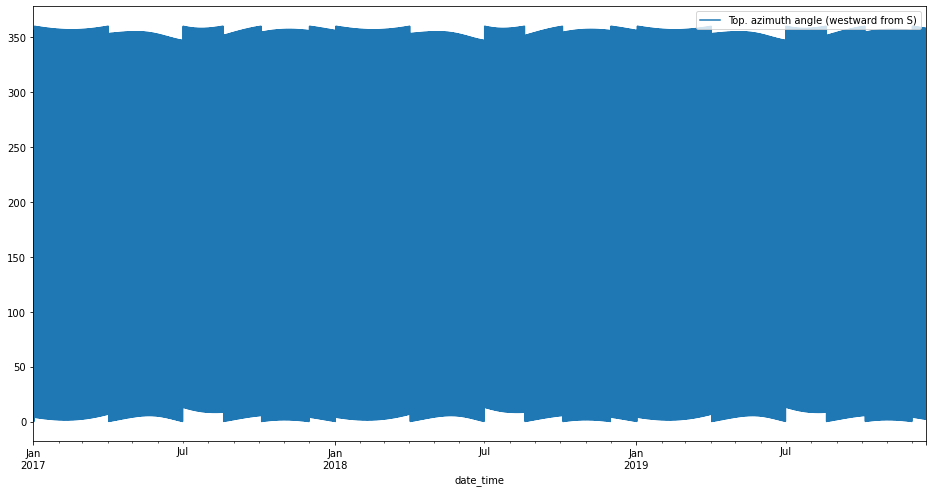

In [10]:
df_train.plot(figsize=(16,8))

In [11]:
len(df_train)

103776

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_train)

MinMaxScaler()

In [13]:
scaled_train=scaler.transform(df_train)
scaled_test =scaler.transform(df_test)
scaled_val=scaler.transform(df_val)

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
n_input =4
n_features =1
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size = 1)


In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [17]:
model =Sequential()
model.add(LSTM(64,activation ="relu",input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer ="adam",loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit_generator(train_generator,epochs=10)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
103772/103772 [==============================] - 256s 2ms/step - loss: 0.0103
Epoch 2/10
103772/103772 [==============================] - 273s 3ms/step - loss: 0.0077
Epoch 3/10
103772/103772 [==============================] - 267s 3ms/step - loss: 0.0073
Epoch 4/10
103772/103772 [==============================] - 267s 3ms/step - loss: 0.0069
Epoch 5/10
103772/103772 [==============================] - 282s 3ms/step - loss: 0.0062
Epoch 6/10
103772/103772 [==============================] - 264s 3ms/step - loss: 0.0059
Epoch 7/10
103772/103772 [==============================] - 285s 3ms/step - loss: 0.0050
Epoch 8/10
103772/103772 [==============================] - 295s 3ms/step - loss: 0.0045
Epoch 9/10
103772/103772 [==============================] - 258s 2ms/step - loss: 0.0037
Epoch 10/10
103772/103772 [==============================] - 274s 3ms/step - loss: 0.0035


In [19]:
model.history.history.keys()  

dict_keys(['loss'])

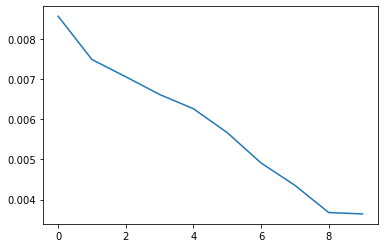

In [20]:
myloss = model.history.history["loss"]
plt.plot(range(len(myloss)),myloss)

Forecast Visualisation

In [21]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [22]:
true_predictions = scaler.inverse_transform(test_predictions)

In [23]:
true_predictions

array([[130.53810907],
       [136.75524973],
       [143.35055414],
       [150.33923466],
       [157.70820307],
       [165.4156629 ],
       [173.39304045],
       [181.54895421],
       [189.77560872],
       [197.94594097],
       [205.93187951],
       [213.61758285],
       [220.85607673],
       [227.54065996],
       [233.60145003],
       [239.00617696],
       [243.75820937],
       [247.88919499],
       [251.44970586],
       [254.52354949],
       [257.20382391],
       [259.56697718],
       [261.6754251 ],
       [263.55356326],
       [265.23271756],
       [266.73661844],
       [268.08835266],
       [269.30735946],
       [270.41799151],
       [271.43790717],
       [272.3826192 ],
       [273.27212469],
       [274.12170038],
       [274.94303985],
       [275.74425349],
       [276.53109155],
       [277.30748048],
       [278.07614522],
       [278.83884517],
       [279.59676041],
       [280.35059898],
       [281.10079002],
       [281.84754809],
       [282

In [24]:
df_test['Predictions'] = true_predictions

<AxesSubplot:xlabel='date_time'>

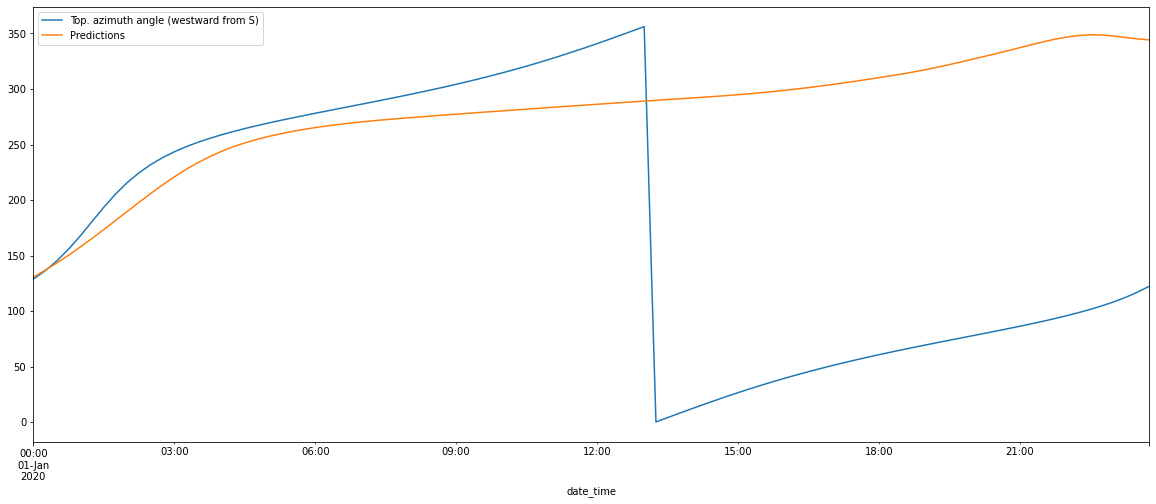

In [25]:
df_test.plot(figsize=(20,8))